In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid, get_circular_mask

from numpy.ma import masked_array

from scipy.linalg import hadamard

import os.path as op
from ekarus.e2e.utils import my_fits_package as myfits


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], 
                                cmap='twilight', vmin= -24)
    plt.title(title)
    plt.xlabel(xp.asnumpy(xlabel))
    plt.ylabel(xp.asnumpy(ylabel))
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(xp.asnumpy(zlabel))

def showZoomCenter(image, pixelSize, maxValLog=None, red=0.2, mask=None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-red)), int(imageHalfSizeInPoints*(1+red))]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxValLog is None:
        maxValLog = xp.max(imageZoomedLog)
    imageZoomedLog = xp.asnumpy(imageZoomedLog-maxValLog)
    if mask is not None:
        imageZoomedLog = masked_array(imageZoomedLog, mask=xp.asnumpy(1-mask[roi[0]: roi[1], roi[0]:roi[1]]))
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

In [3]:
def lyot_coronograph(focal_field, occulter_radius, lyot_stop:float=0.95, oversampling:int=4):
    focal_mask = get_circular_mask(focal_field.shape,mask_radius=occulter_radius*oversampling)
    lyot_stop = 1-get_circular_mask(focal_field.shape,mask_radius=lyot_stop*max(focal_field.shape)*oversampling)
    field_after_stop = focal_field * focal_mask
    pupil = xp.fft.ifft2(xp.fft.ifftshift(field_after_stop))
    lyot_pupil = pupil * lyot_stop
    coro_focal_field = xp.fft.fftshift(xp.fft.fft2(lyot_pupil))
    coro_psf = xp.abs(coro_focal_field)**2
    return coro_psf

def knife_edge_coronograph(focal_field, iwa:float, owa:float, f_edge:float, oversampling:int=4):
    X,_ = image_grid(focal_field.shape,recenter=True)
    knife_edge = (X<f_edge*oversampling)
    iwa_stop = get_circular_mask(focal_field.shape,mask_radius=iwa*oversampling)
    owa_stop= 1-get_circular_mask(focal_field.shape,mask_radius=owa*oversampling)
    lyot_stop = 1-xp.logical_xor(iwa_stop, owa_stop)
    field_after_mask = focal_field * knife_edge
    pupil = xp.fft.ifft2(xp.fft.ifftshift(field_after_mask))
    lyot_pupil = pupil * lyot_stop
    coro_focal_field = xp.fft.fftshift(xp.fft.fft2(lyot_pupil))
    coro_psf = xp.abs(coro_focal_field)**2
    return coro_psf

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Unobscured actuators: 752/820
Fried parameter is: 5.0 [cm] (seeing = 2.02")


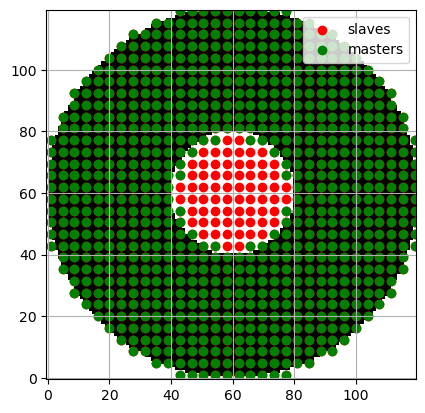

In [4]:
ssao = SingleStageAO(tn='high_contrast')
ssao.initialize_turbulence('ekarus_5cm')
# KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=2)

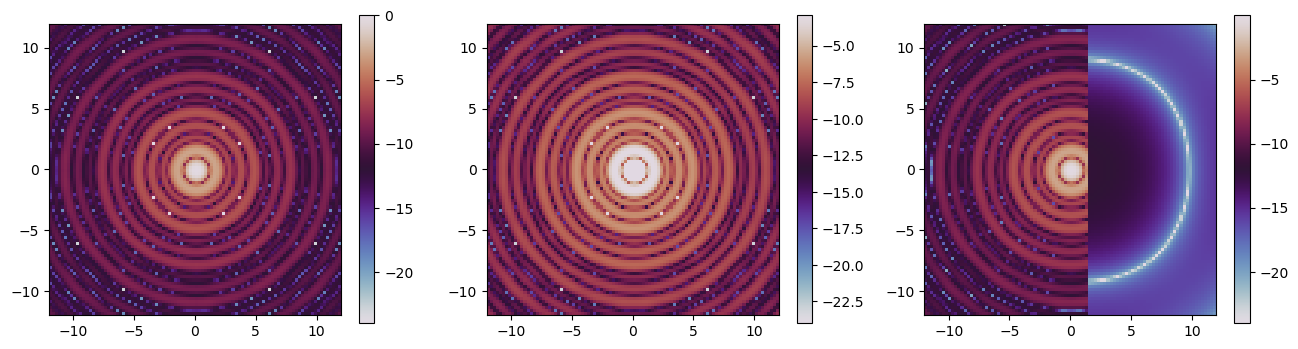

In [5]:
oversampling = 4
input_field = (1-ssao.cmask) * xp.exp(1j*xp.zeros(ssao.cmask.shape))
padded_field = xp.pad(input_field, pad_width=(oversampling-1)*int(max(ssao.cmask.shape))//2, mode='constant', constant_values=0.0)
focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
coro_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
ke_psf = knife_edge_coronograph(focal_field, iwa=2, owa=62, f_edge=1.5)
psf = xp.abs(focal_field**2)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,2)
showZoomCenter(coro_psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,3)
showZoomCenter(ke_psf, 1/oversampling, xp.max(xp.log(psf)))

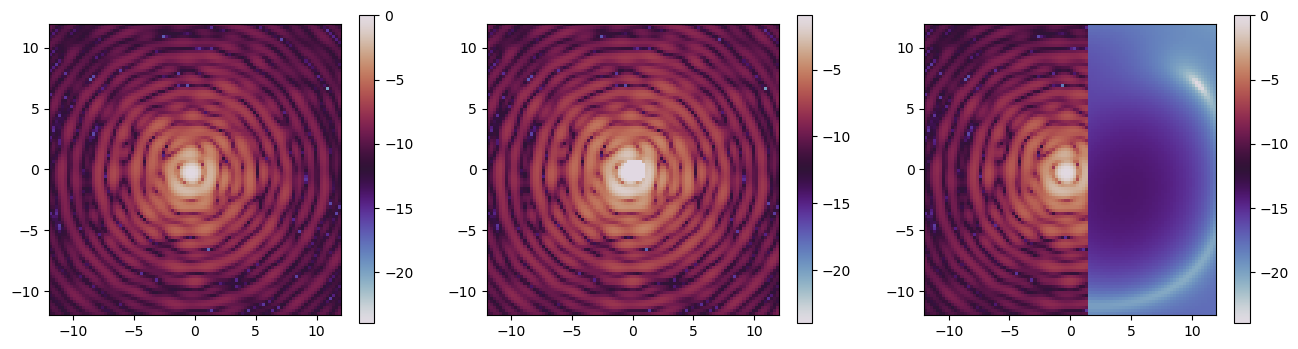

In [6]:
atmo_phase = ssao.get_phasescreen_at_time(0.0)/10
phi = (atmo_phase - xp.mean(atmo_phase))
lambdaInM = 800e-9
phi *= 2*xp.pi/lambdaInM

oversampling = 4
input_field = (1-ssao.cmask) * xp.exp(1j*phi)
padded_field = xp.pad(input_field, pad_width=(oversampling-1)*int(max(ssao.cmask.shape))//2, mode='constant', constant_values=0.0)
focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
coro_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
ke_psf = knife_edge_coronograph(focal_field, iwa=2, owa=62, f_edge=1.5)
psf = xp.abs(focal_field**2)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,2)
showZoomCenter(coro_psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,3)
showZoomCenter(ke_psf, 1/oversampling, xp.max(xp.log(psf)))

In [7]:
def get_dark_and_bright_fields(field_shape,edge,iwa,dh_owa,bf_owa,oversampling):

    new_shape = (field_shape[0]*oversampling,field_shape[1]*oversampling)
    X,_ = image_grid(new_shape,recenter=True)

    iwa_stop = get_circular_mask(new_shape,mask_radius=iwa*oversampling)
    owa_stop= 1-get_circular_mask(new_shape,mask_radius=dh_owa*oversampling)

    dark_hole = (X>=edge)
    dark_hole = xp.logical_and(dark_hole, owa_stop)
    dark_hole = xp.logical_and(dark_hole, iwa_stop)

    owa_stop= 1-get_circular_mask(new_shape,mask_radius=bf_owa*oversampling)

    bright_field = owa_stop
    bright_field = xp.logical_and(bright_field, ~dark_hole)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(xp.asnumpy(dark_hole),origin='lower',cmap='grey')
    plt.subplot(1,2,2)
    plt.imshow(xp.asnumpy(bright_field),origin='lower',cmap='grey')

    return dark_hole, bright_field

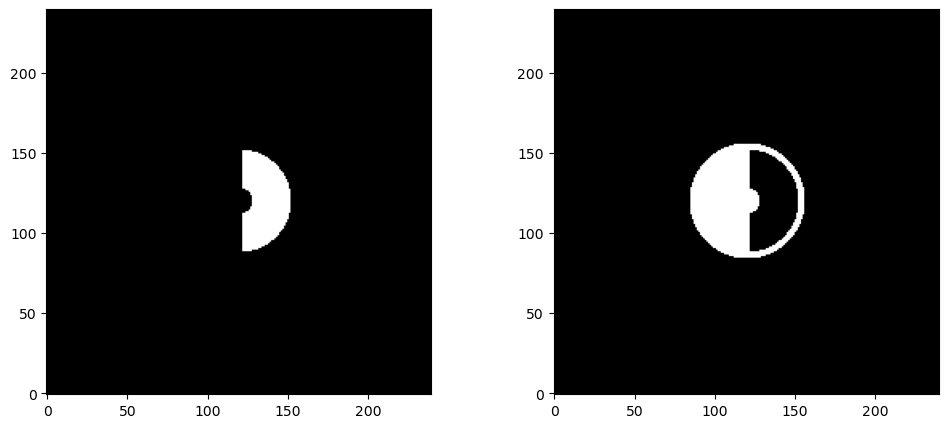

In [8]:
oversampling = 2
dark_hole, bright_field = get_dark_and_bright_fields(input_field.shape, edge=2, iwa=4, dh_owa=16, bf_owa=18, oversampling=oversampling)

In [9]:
filename = op.join(ssao.savecalibpath,'dark_hole_intmat.fits')

try:
    IntMat = myfits.read_fits(filename)
except FileNotFoundError:
    hadamat = hadamard(2**xp.ceil(xp.log(ssao.dm.Nacts)/xp.log(2)))
    hadamat = hadamat[1:ssao.dm.Nacts+1,:]
    hadamat = hadamat[:,1:ssao.dm.Nacts+1]

    occulter_radius = 1
    lyot_stop = 1.0

    IntMat = xp.zeros([int(xp.sum(1-dark_hole)),ssao.dm.Nacts])

    pad_width = (oversampling-1)*int(max(ssao.cmask.shape))//2

    amp = 2*xp.pi/lambdaInM * 10e-9

    for j in range(ssao.dm.Nacts):
        dm_cmd = xp.asarray(hadamat[j,:])
        mode = ssao.dm.IFF @ dm_cmd
        dm_phase = reshape_on_mask(mode*amp, ssao.dm.mask)
        input_field = (1-ssao.cmask) * xp.exp(1j*dm_phase)
        padded_field = xp.pad(input_field, pad_width=pad_width, mode='constant', constant_values=0.0)

        focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
        coro_psf = lyot_coronograph(focal_field, occulter_radius=occulter_radius, lyot_stop=lyot_stop, oversampling=oversampling)
        push_dh = coro_psf[~dark_hole]
        focal_field = xp.fft.fftshift(xp.fft.fft2(xp.conj(padded_field)))
        coro_psf = lyot_coronograph(focal_field, occulter_radius=occulter_radius, lyot_stop=lyot_stop, oversampling=oversampling)
        pull_dh = coro_psf[~dark_hole]

        IntMat[:,j] = (push_dh-pull_dh)/(2*amp)
    myfits.save_fits(filename, IntMat)
    

In [10]:
filename = op.join(ssao.savecalibpath,'bright_field_intmat.fits')

try:
    IntMat = myfits.read_fits(filename)
except FileNotFoundError:
    hadamat = hadamard(2**xp.ceil(xp.log(ssao.dm.Nacts)/xp.log(2)))
    hadamat = hadamat[1:ssao.dm.Nacts+1,:]
    hadamat = hadamat[:,1:ssao.dm.Nacts+1]

    occulter_radius = 1
    lyot_stop = 1.0

    IntMat = xp.zeros([int(xp.sum(1-bright_field)),ssao.dm.Nacts])

    pad_width = (oversampling-1)*int(max(ssao.cmask.shape))//2

    amp = 2*xp.pi/lambdaInM * 10e-9

    for j in range(ssao.dm.Nacts):
        dm_cmd = xp.asarray(hadamat[j,:])
        mode = ssao.dm.IFF @ dm_cmd
        dm_phase = reshape_on_mask(mode*amp, ssao.dm.mask)
        input_field = (1-ssao.cmask) * xp.exp(1j*dm_phase, dtype=xp.complex64)
        padded_field = xp.pad(input_field, pad_width=pad_width, mode='constant', constant_values=0.0)

        focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
        coro_psf = lyot_coronograph(focal_field, occulter_radius=occulter_radius, lyot_stop=lyot_stop, oversampling=oversampling)
        push_dh = coro_psf[~bright_field]
        focal_field = xp.fft.fftshift(xp.fft.fft2(xp.conj(padded_field)))
        coro_psf = lyot_coronograph(focal_field, occulter_radius=occulter_radius, lyot_stop=lyot_stop, oversampling=oversampling)
        pull_dh = coro_psf[~bright_field]

        IntMat[:,j] = (push_dh-pull_dh)/(2*amp)
    myfits.save_fits(filename, IntMat)

(54985, 820) (820, 820)


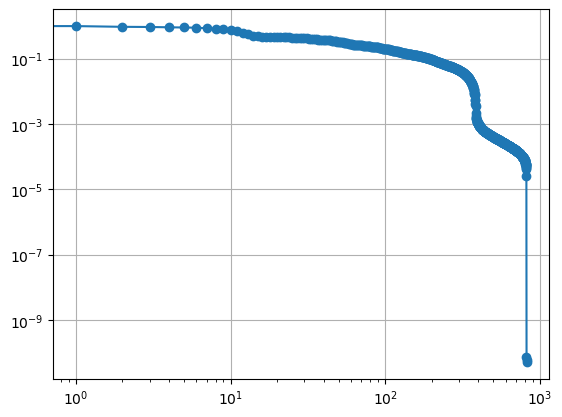

In [11]:
U,D,V = xp.linalg.svd(IntMat, full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(D/max(D)),'-o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

print(U.shape,V.shape)

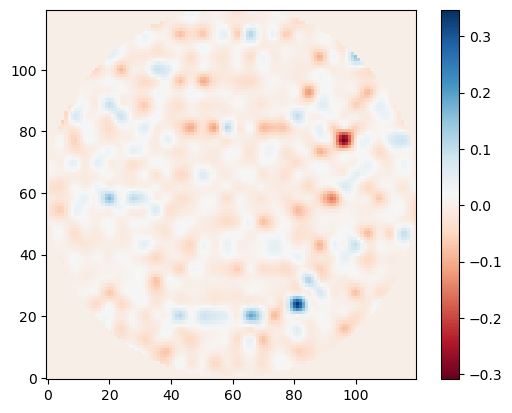

In [12]:
i = 10

plt.figure()
plt.imshow(xp.asnumpy(reshape_on_mask(ssao.dm.IFF @ V[i,:], ssao.dm.mask)),origin='lower',cmap='RdBu')
plt.colorbar()

In [13]:
def get_tikhonov_rec(U,S,V,gamma:float=1e-4):    
    Sinv = 1/S
    LAMBDA = S**2/(gamma+S**2) * Sinv
    LAMBDA[S/max(S)>gamma] = Sinv[S/max(S)>gamma]
    newRec = (V.T * LAMBDA) @ U.T
    return newRec, LAMBDA

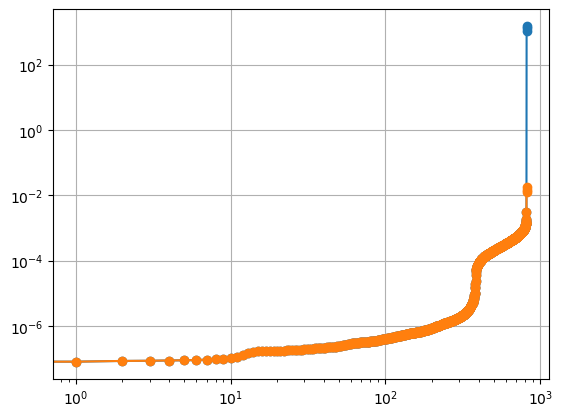

In [14]:
Rec, LAMBDA = get_tikhonov_rec(U,D,V,gamma=5e-2)

plt.figure()
plt.plot(xp.asnumpy(1/D),'-o')
plt.plot(xp.asnumpy(LAMBDA),'-o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

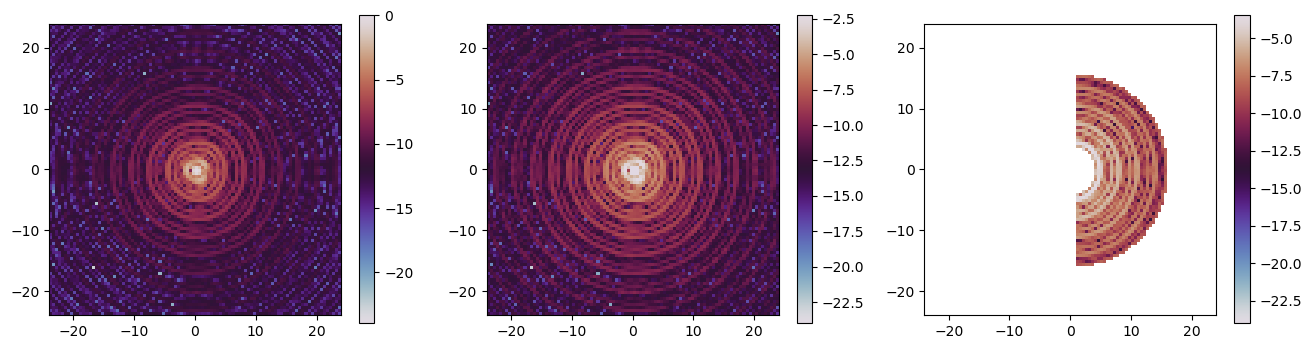

In [34]:
atmo_phase = ssao.get_phasescreen_at_time(2.0)/20
phi = (atmo_phase - xp.mean(atmo_phase))
lambdaInM = 800e-9
m2rad = 2*xp.pi/lambdaInM
phi *= m2rad

input_field = (1-ssao.cmask) * xp.exp(1j*phi)
padded_field = xp.pad(input_field, pad_width=(oversampling-1)*int(max(ssao.cmask.shape))//2, mode='constant', constant_values=0.0)
focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
coro_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
psf = xp.abs(focal_field**2)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)), red=0.4)
plt.subplot(1,3,2)
showZoomCenter(coro_psf, 1/oversampling, xp.max(xp.log(psf)), red=0.4)
plt.subplot(1,3,3)
showZoomCenter(coro_psf, 1/oversampling,  mask = dark_hole, red=0.4)

4.4717184200718725 18.031023010094522
5.144819818236877 18.031023010094522


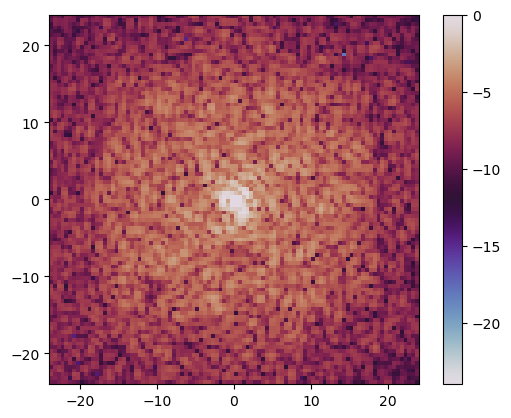

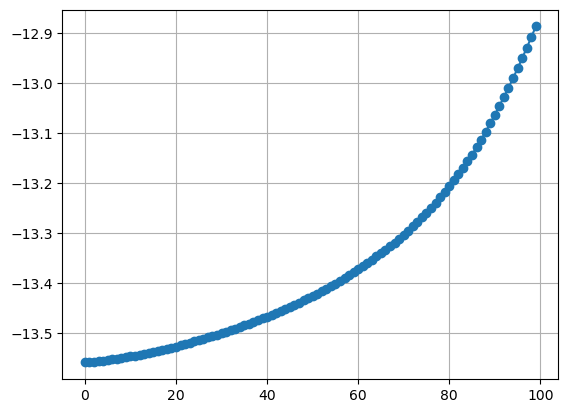

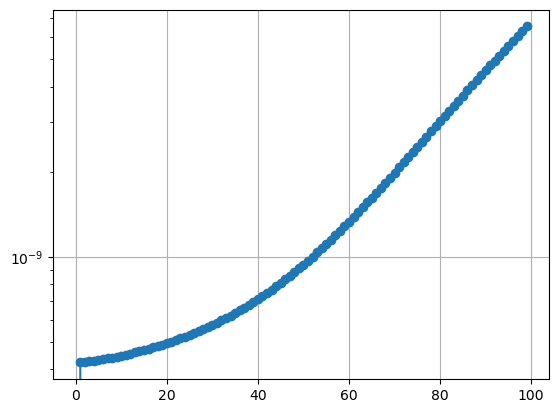

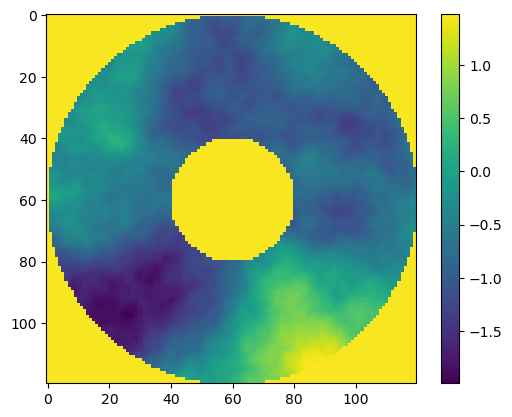

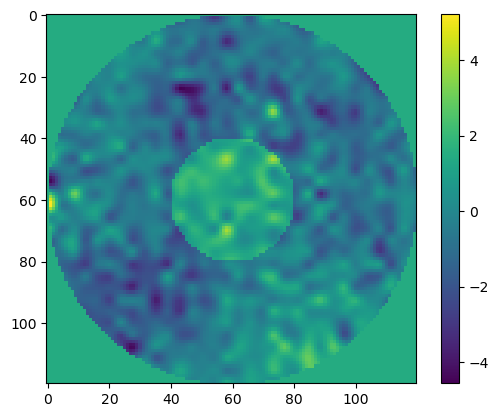

In [33]:
Nits = 100
bf_psf = coro_psf[~bright_field]
dh_psf = coro_psf[~dark_hole]
mean_contrast = xp.ones(Nits) * xp.mean(xp.log(dh_psf)-xp.max(xp.log(psf)))
dm_cmds = xp.zeros([Nits,ssao.dm.Nacts])

print(xp.mean(xp.log(dh_psf)),xp.max(xp.log(psf)))
phase = phi.copy()
gain = 1e-3

for i in range(1,Nits):
    dm_cmd = Rec @ bf_psf
    dm_phase = ssao.dm.IFF @ dm_cmd
    phase -= gain*reshape_on_mask(dm_phase,ssao.dm.mask)
    input_field = (1-ssao.cmask) * xp.exp(1j*phase,dtype=xp.complex64)
    padded_field = xp.pad(input_field, pad_width=(oversampling-1)*int(max(ssao.cmask.shape))//2, mode='constant', constant_values=0.0)
    focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
    cor_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
    bf_psf = cor_psf[~bright_field]
    dh_psf = cor_psf[~dark_hole]

    dm_cmds[i,:] = dm_cmd/m2rad
    mean_contrast[i] = xp.mean(xp.log(dh_psf)-xp.max(xp.log(psf)))

print(xp.mean(xp.log(dh_psf)),xp.max(xp.log(psf)))
plt.figure()
showZoomCenter(cor_psf, 1/oversampling, red=0.4) #mask = dark_hole, 

plt.figure()
plt.plot(xp.asnumpy(mean_contrast),'-o')
plt.grid()

plt.figure()
plt.plot(xp.asnumpy(xp.sum(dm_cmds**2,axis=1)),'-o')
plt.grid()
plt.yscale('log')


plt.figure()
plt.imshow(xp.asnumpy(phi))
plt.colorbar()

plt.figure()
plt.imshow(xp.asnumpy(phase))
plt.colorbar()